In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None



Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [2]:
print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()






Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 1.512642s
n_samples: 3387, n_features: 10000



In [3]:
opts.n_components

In [5]:
if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

In [7]:
X.shape

(3387, 10000)

In [8]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

In [9]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=False)
done in 8.309s



In [10]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.418
Completeness: 0.469
V-measure: 0.442
Adjusted Rand-Index: 0.379
Silhouette Coefficient: 0.007


In [ ]:
# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [11]:
from sklearn.datasets import load_files

# for reproducibility
random_state = 0 

DATA_DIR = "./bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './bbc/'

In [12]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(dataset.data)
features = vec.transform(dataset.data)

In [14]:
features.shape

(3387, 43255)

In [15]:
cls = MiniBatchKMeans(n_clusters=20, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [16]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([3, 1, 1, ..., 0, 1, 1], dtype=int32)

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

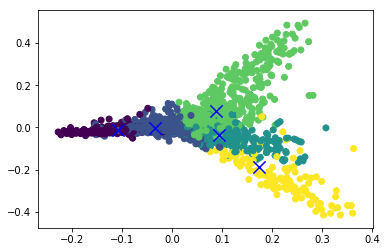

In [20]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')